# Pandas dataframe accessor: Levi graph
## Transform between different graph data repressentations via a Levi graph

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import networkx as nx
import matplotlib.pyplot as plt
import beartype as bt

plt.rcParams['figure.dpi'] = 60

### Create data to use in development:
- Token Co-occurrence matrix
- Document-term matrix (this is an example of a bipartite structure/incidence matrix)
- COO (format: multi-index pandas Series)


In [2]:
# Create sample dataset

doc_ids = [str(x) for x in range(5)]
texts = [
    "the quick brown fox jumped",
    "the fox jumped",
    "the dog jumped",
    "one brown fox",
    "ten brown dogs",
   ]

df = pd.DataFrame({'doc_id': doc_ids,
                    'text':texts,
                    })

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words=['the'])
cv.fit(df['text'])
tokens = cv.get_feature_names_out()  #alphabetical

In [4]:
# Create cooccurence matrix

results = cv.transform(df['text'])
coocc = results.T.dot(results)
# np.fill_diagonal(coocc.values, 0)
coocc = pd.DataFrame(results.T.dot(results).toarray(), index=tokens, columns=tokens)
np.fill_diagonal(coocc.values, 0)
coocc

,brown,dog,dogs,fox,jumped,one,quick,ten
brown,0,0,1,2,1,1,1,1
dog,0,0,0,0,1,0,0,0
dogs,1,0,0,0,0,0,0,1
fox,2,0,0,0,2,1,1,0
jumped,1,1,0,2,0,0,1,0
one,1,0,0,1,0,0,0,0
quick,1,0,0,1,1,0,0,0
ten,1,0,1,0,0,0,0,0


In [5]:
# Create document term matrix (BIPARTITE STRUCTURE)

results = cv.transform(df['text'])
features = cv.get_feature_names_out()
doc_term = pd.DataFrame(results.toarray(), columns=features)
doc_term = doc_term.reindex(columns=doc_term.columns.tolist()+['cat', 'bear', 'tree'], fill_value=0)
doc_term

,brown,dog,dogs,fox,jumped,one,quick,ten,cat,bear,tree
0,1,0,0,1,1,0,1,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0
3,1,0,0,1,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,1,0,0,0


In [6]:
# Create COO Dataframe
# using scipy sparse module here, but we want to avoid it in production
coo_matrix = sparse.coo_matrix(doc_term.values)
coo_rows = coo_matrix.row
coo_cols = coo_matrix.col
coo_vals = coo_matrix.data

term_dict = dict(zip(range(0,11), doc_term.columns))
term_dict

{0: 'brown',
 1: 'dog',
 2: 'dogs',
 3: 'fox',
 4: 'jumped',
 5: 'one',
 6: 'quick',
 7: 'ten',
 8: 'cat',
 9: 'bear',
 10: 'tree'}

In [7]:
coo_cols = coo_cols.tolist()
coo_col_names = [term_dict[key] for key in coo_cols]

In [8]:
idx=pd.MultiIndex.from_arrays([coo_matrix.row, coo_col_names])
coo = pd.DataFrame(coo_matrix.data, index=idx, columns=["flag"])
coo

flag
0 brown      1
  fox        1
  jumped     1
  quick      1
1 fox        1
  jumped     1
2 dog        1
  jumped     1
3 brown      1
  fox        1
  one        1
4 brown      1
  dogs       1
  ten        1

In [9]:
levi_series = coo.squeeze()
levi_series

0  brown     1
   fox       1
   jumped    1
   quick     1
1  fox       1
   jumped    1
2  dog       1
   jumped    1
3  brown     1
   fox       1
   one       1
4  brown     1
   dogs      1
   ten       1
Name: flag, dtype: int64

In [10]:
from levi import dataframe, series

levi_series.levi.to_edgelist(level_0="doc", level_1="term")

/Users/amc8/grabble/notebooks/levi/__init__.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


,doc,term,flag
0,0,brown,1
1,0,fox,1
2,0,jumped,1
3,0,quick,1
4,1,fox,1
5,1,jumped,1
6,2,dog,1
7,2,jumped,1
8,3,brown,1
9,3,fox,1


In [12]:
from levi import series

levi_series.levi.to_adjacency

,brown,dog,dogs,fox,jumped,one,quick,ten
brown,0,0,1,2,1,1,1,1
dog,0,0,0,0,1,0,0,0
dogs,1,0,0,0,0,0,0,1
fox,2,0,0,0,2,1,1,0
jumped,1,1,0,2,0,0,1,0
one,1,0,0,1,0,0,0,0
quick,1,0,0,1,1,0,0,0
ten,1,0,1,0,0,0,0,0


In [14]:
coo.squeeze()

level_0  level_1
0        brown      1
         fox        1
         jumped     1
         quick      1
1        fox        1
         jumped     1
2        dog        1
         jumped     1
3        brown      1
         fox        1
         one        1
4        brown      1
         dogs       1
         ten        1
Name: flag, dtype: int64

In [15]:
print(coo_matrix)  #scipy sparse format

  (0, 0)	1
  (0, 3)	1
  (0, 4)	1
  (0, 6)	1
  (1, 3)	1
  (1, 4)	1
  (2, 1)	1
  (2, 4)	1
  (3, 0)	1
  (3, 3)	1
  (3, 5)	1
  (4, 0)	1
  (4, 2)	1
  (4, 7)	1


In [21]:
def edgelist_to_incidence(edgelist, node_colname, value_colname=None):
    """assume edgelist is indexed by edge number, not some edge set of names (for now)"""
    data = np.ones_like(edgelist.index.values) if value_colname == None else edgelist[value_colname].values
    return sparse.coo_array((data, (edgelist.index, edgelist[node_colname].cat.codes)), shape=(edgelist.shape[0], len(edgelist[node_colname].cat.categories)))  # coo_array((data, (row_idx, col_idx)))

In [27]:
edgelist = levi_series.levi.to_edgelist(level_0="doc", level_1="term")
edgelist['doc'] = pd.Categorical(edgelist.doc)
edgelist['term'] = pd.Categorical(edgelist.term)

In [28]:
edgelist

,doc,term,flag
0,0,brown,1
1,0,fox,1
2,0,jumped,1
3,0,quick,1
4,1,fox,1
5,1,jumped,1
6,2,dog,1
7,2,jumped,1
8,3,brown,1
9,3,fox,1


In [29]:
inc = edgelist_to_incidence(edgelist, node_colname='term')
print(inc)

  (0, 0)	1
  (1, 3)	1
  (2, 4)	1
  (3, 6)	1
  (4, 3)	1
  (5, 4)	1
  (6, 1)	1
  (7, 4)	1
  (8, 0)	1
  (9, 3)	1
  (10, 5)	1
  (11, 0)	1
  (12, 2)	1
  (13, 7)	1


In [30]:
inc_frame = pd.DataFrame(inc.data, index=edgelist)
inc_frame

,0
"(0, brown, 1)",1
"(0, fox, 1)",1
"(0, jumped, 1)",1
"(0, quick, 1)",1
"(1, fox, 1)",1
"(1, jumped, 1)",1
"(2, dog, 1)",1
"(2, jumped, 1)",1
"(3, brown, 1)",1
"(3, fox, 1)",1


In [31]:
# tuple_list = list(zip(coo_rows, coo_col_names, coo_matrix.data))
tuple_list = list(zip(coo_rows, coo_col_names, ))
tuple_list_w_data = [(*t, 1) for t in tuple_list]

In [32]:
import itertools
row_index = dict(zip(tuple_list_w_data, itertools.count()))
row_index

{(0, 'brown', 1): 0,
 (0, 'fox', 1): 1,
 (0, 'jumped', 1): 2,
 (0, 'quick', 1): 3,
 (1, 'fox', 1): 4,
 (1, 'jumped', 1): 5,
 (2, 'dog', 1): 6,
 (2, 'jumped', 1): 7,
 (3, 'brown', 1): 8,
 (3, 'fox', 1): 9,
 (3, 'one', 1): 10,
 (4, 'brown', 1): 11,
 (4, 'dogs', 1): 12,
 (4, 'ten', 1): 13}

In [33]:
# array_x = nx.algorithms.bipartite.biadjacency_matrix(graph, row_order=tuple_list_w_data)
# array_x

In [34]:
# Make sure pandas categorical works with ints
#   - in nb, ss example has index as ints, not categoricals
#   - pandas_categoricals

In [35]:
from phantom import Phantom
from phantom.predicates import Predicate
import beartype.typing as bt
from beartype.door import is_bearable


In [36]:
def of_beartype(t: bt.Union[type, bt.Tuple[type, ...]]) -> Predicate[object]:
    """ From `phantom.predicates.generic.of_type`

    Create a new predicate that succeeds when its argument is bearable on ``t``.
    """

    def check(a: object) -> bool:
        return is_bearable(a, t)

    return check

In [37]:
# chck = of_beartype(coo)
# chck(coo)

In [38]:
coo.unstack(level=1, )

flag                                      
level_1 brown  dog dogs  fox jumped  one quick  ten
level_0                                            
0         1.0  NaN  NaN  1.0    1.0  NaN   1.0  NaN
1         NaN  NaN  NaN  1.0    1.0  NaN   NaN  NaN
2         NaN  1.0  NaN  NaN    1.0  NaN   NaN  NaN
3         1.0  NaN  NaN  1.0    NaN  1.0   NaN  NaN
4         1.0  NaN  1.0  NaN    NaN  NaN   NaN  1.0

In [39]:
type(coocc)

pandas.core.frame.DataFrame

In [40]:
import levi

coo.levi

For now, assume "input" is a doc-term matrix

In [41]:
# from affinity-to-edge

def affinity_to_edge(source_name,  # type: str
    target_name,  # type: str
    affinity,  # type: DF
    value_name=None  # type: Optional[str]
    ):
# type: (...) -> DF
    """DEPRECATED"""
    return (affinity.reset_index().melt(source_name, value_name=value_name, var_name=target_name).query('weight>0'))


In [42]:
doc_term

,brown,dog,dogs,fox,jumped,one,quick,ten,cat,bear,tree
0,1,0,0,1,1,0,1,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0
3,1,0,0,1,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,1,0,0,0


In [43]:
ids = ('id-student', 'id-project')

testing = doc_term.reset_index().melt(0, value_name="brown", ).query('weight>0')   #var_name=target_name
testing

/var/folders/9n/0tgq9jyd0c937jhb1478vxt80021dq/T/ipykernel_58362/3959394257.py:3: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  testing = doc_term.reset_index().melt(0, value_name="brown", ).query('weight>0')   #var_name=target_name


KeyError: 0

In [ ]:
pd.DataFrame.melt

testing = doc_term.reset_index().melt(source_name, value_name=value_name, var_name=target_name).query('weight>0')
testing

In [ ]:
# @pd.api.extensions.register_dataframe_accessor("levi")   #can also be df, series, or index
# class LeviAccessor:
#     def __init__(self, pandas_obj):
#         self._validate(pandas_obj)
#         self._obj = pandas_obj

#     @staticmethod
#     def _validate(obj):
#         # TODO: use beartype
#         if type(obj) is not pd.DataFrame:
#             raise AttributeError("Must be cooccurrence Dataframe")  #FIXME this is just filler to get accesor to run, need to update
        

#     @property
#     def from_dataframe(self):
#         test = self._obj()
#         return 


  

#     @property
#     def test_attr(self):        
#         return self._obj.iloc[0]
    
#     @property
#     def incidence_matrix(self):
#         return self._obj.unstack(level=1, fill_value=0)
    
    
    

    # def testing(self):
    #     # plot this array's data on a map, e.g., using Cartopy
    #     print(self.__str__)
    #     pass

In [44]:

coo.levi.to_biadjacency

flag                                  
level_1 brown dog dogs fox jumped one quick ten
level_0                                        
0           1   0    0   1      1   0     1   0
1           0   0    0   1      1   0     0   0
2           0   1    0   0      1   0     0   0
3           1   0    0   1      0   1     0   0
4           1   0    1   0      0   0     0   1

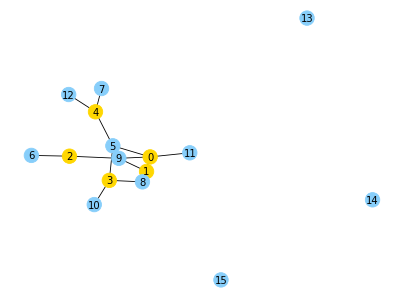

In [46]:
graph = nx.algorithms.bipartite.from_biadjacency_matrix(coo_matrix)
sets = nx.get_node_attributes(graph, name="bipartite")
colors = {0: 'gold', 1: 'lightskyblue'}

nx.draw(graph, with_labels=True, node_color=[colors[node[1]['bipartite']] 
                    for node in graph.nodes(data=True)])


In [47]:
graph.edges()

EdgeView([(0, 5), (0, 8), (0, 9), (0, 11), (1, 8), (1, 9), (2, 6), (2, 9), (3, 5), (3, 8), (3, 10), (4, 5), (4, 7), (4, 12)])

In [48]:
# Plotting with HyperNetx
import hypernetx as hnx

In [49]:
term_doc = doc_term.T

In [50]:
# *HNX* hypergraphs can be built from networkx bipartite graph objects using `from_bipartite`
H = hnx.Hypergraph.from_dataframe(term_doc)

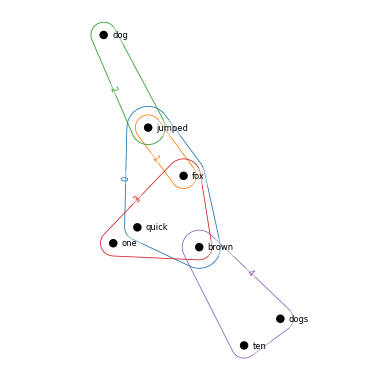

In [51]:
hnx.drawing.draw(H)